In [6]:
# lets explore the data first

In [7]:
random_file = 'data/ETH_2023-08/ETH_2023-08-01.csv'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(random_file)
print(df.head())
print(df.describe())



       open_time     open     high      low    close  volume     close_time  \
0  1690848000000  1856.13  1856.14  1856.13  1856.14  0.4058  1690848000999   
1  1690848001000  1856.14  1856.14  1856.14  1856.14  0.0053  1690848001999   
2  1690848002000  1856.13  1856.14  1856.13  1856.14  0.1845  1690848002999   
3  1690848003000  1856.13  1856.13  1856.13  1856.13  0.5184  1690848003999   
4  1690848004000  1856.14  1856.14  1856.13  1856.13  0.1669  1690848004999   

   count  
0      8  
1      1  
2      2  
3      2  
4      3  
          open_time          open          high           low         close  \
count  8.640000e+04  86400.000000  86400.000000  86400.000000  86400.000000   
mean   1.690891e+12   1838.875713   1838.886982   1838.865101   1838.876088   
std    2.494168e+07     11.386952     11.388271     11.386565     11.387706   
min    1.690848e+12   1814.990000   1815.400000   1813.800000   1814.990000   
25%    1.690870e+12   1830.990000   1830.990000   1830.970000   

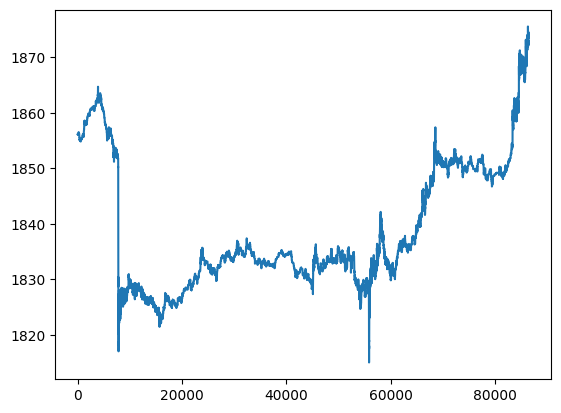

In [9]:
# lets plot the data
plt.plot(df['close'])
plt.show()


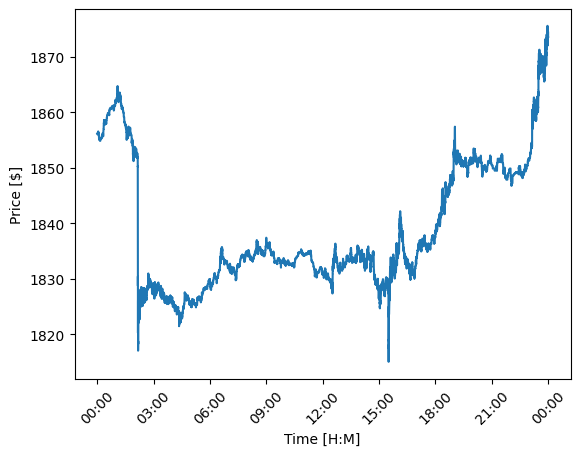

In [10]:
# lets try again but now add axis labels
x_axis = pd.to_datetime(df['open_time'], unit='ms')
plt.plot(x_axis, df['close'])
# keep only the hours and minutes on the x axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.xlabel('Time [H:M]')
plt.ylabel('Price [$]')
plt.show()

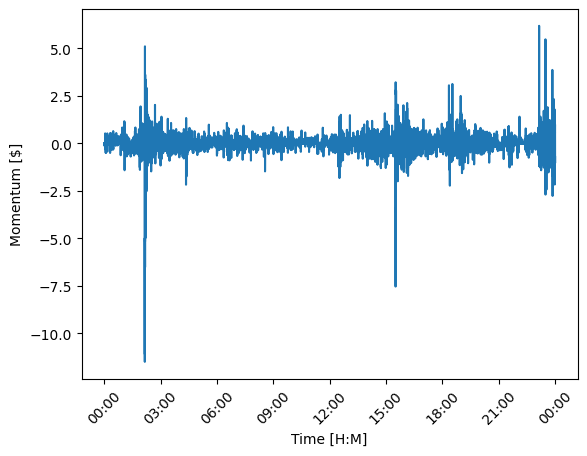

In [11]:
# calculate momentum 
k = 10 # momentum window
df['momentum'] = df['close'] - df['close'].shift(k)
plt.plot(x_axis, df['momentum'])
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.xlabel('Time [H:M]')
plt.ylabel('Momentum [$]')
plt.show()

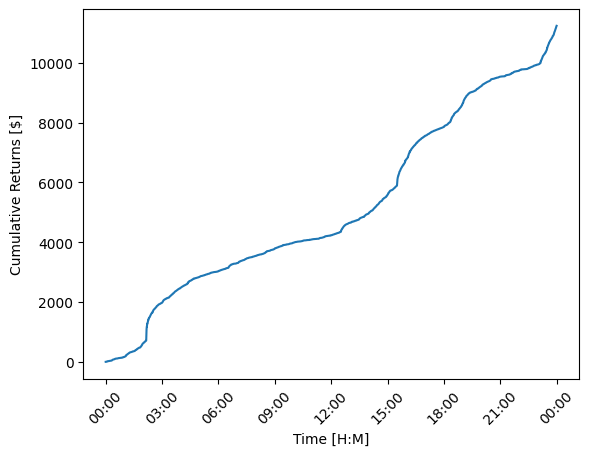

In [12]:
# trend following strategy
# if momentum is positive, buy
# if momentum is negative, sell
# if momentum is zero, do nothing
# lets calculate the returns of this strategy
df['position'] = np.where(df['momentum'] > 0, 1, 0)
df['position'] = np.where(df['momentum'] < 0, -1, df['position'])
df['position'] = df['position'].shift(1)
df['returns'] = df['position'] * df['momentum']
df['cumulative_returns'] = df['returns'].cumsum()
plt.plot(x_axis, df['cumulative_returns'])
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.xlabel('Time [H:M]')
plt.ylabel('Cumulative Returns [$]')
plt.show()


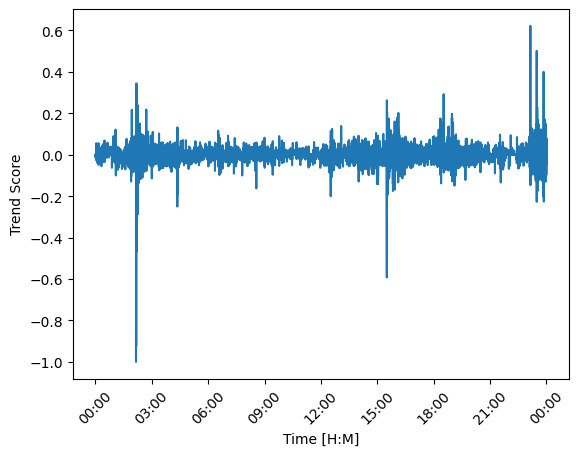

In [19]:
# Trend Score Calculation
# For each new line of data, calculate a score normalized to [-1, 1] to reflect the trend strength and direction.
# For instance, if momentum (or another trend indicator) is positive and strong, assign a score close to 1 (strong upward trend). If momentum is strongly negative, assign a score close to -1 (strong downward trend).
# Use a smoothing method (e.g., rolling average) to avoid over-reacting to noise in the data.

# lets calculate the trend score
k = 5 # trend score period
df['trend_score'] = df['momentum'].rolling(k).mean()
df['trend_score'] = df['trend_score'] / df['trend_score'].abs().max()
plt.plot(x_axis, df['trend_score'])
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.xlabel('Time [H:M]')
plt.ylabel('Trend Score')
plt.show()


In [ ]:
# lets put everything together
def calculate_trend_score(data):
    """
    Calculate the trend score based on the price momentum.
    The score will be normalized to the range [-1, 1].
    """
    # Ensure there's enough data to compute the momentum (at least 2 rows)
    if len(data) < 2:
        return 0

    # Calculate the momentum as the difference between the current and previous close prices
    momentum = data['close'].diff()  # Simple price difference
    
    # Avoid division by zero or very small values
    momentum_max = momentum.abs().max()
    if momentum_max == 0 or pd.isna(momentum_max):
        return 0
    
    # Normalize the most recent momentum value to [-1, 1]
    score = momentum.iloc[-1] / momentum_max
    
    return score

In [20]:
# process the data
from os import path
import pandas as pd
from tqdm import tqdm

input_file: str = 'data/ETH_2023-08/ETH_2023-08-01.csv'
output_dir: str = 'output'
output_file = path.join(output_dir, path.basename(input_file))



In [ ]:

"""
Process the input CSV file, calculate trend scores, and save them to an output CSV.
"""
# Initialize a buffer to store up to 60 rows of data for the rolling window
buffer = pd.DataFrame()

# Initialize an empty list to store the results
output_data = []

# Get total number of lines in the file (minus the header) for progress tracking
total_lines = sum(1 for _ in open(input_file)) - 1

# Read CSV file line by line using tqdm for progress tracking
with tqdm(total=total_lines, desc="Processing data") as pbar:
    for chunk in pd.read_csv(input_file, chunksize=1):
        # Add the new row to the buffer
        buffer = pd.concat([buffer, chunk], ignore_index=True)
        
        # Keep only the last 60 rows in the buffer for a 1-minute window
        if len(buffer) > 60:
            buffer = buffer.iloc[-60:]
        
        # Calculate the trend score based on the current buffer
        trend_score = calculate_trend_score(buffer)
        
        # Append the result (close_time and trend score)
        output_data.append([chunk['close_time'].values[0], trend_score])
        
        # Update progress bar
        pbar.update(1)

# Write the output to a CSV file
pd.DataFrame(output_data, columns=["time", "score"]).to_csv(output_file, index=False)
print(f"Processing complete. Output saved to {output_file}")


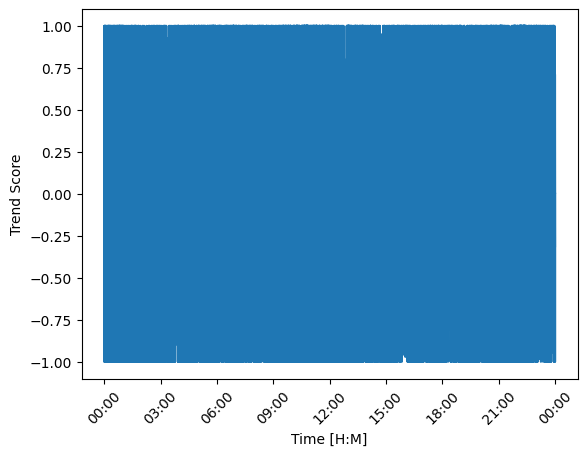

In [21]:
# lets plot the trend score
df = pd.read_csv(output_file)
x_axis = pd.to_datetime(df['time'], unit='ms')
plt.plot(x_axis, df['score'])
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.xlabel('Time [H:M]')
plt.ylabel('Trend Score')
plt.show()


In [ ]:
# lets backtest the strategy
import pandas as pd

def backtest(input_file):
    """
    Backtest the model using the historical data and actions.
    Simulates buy/sell actions and tracks profit/loss.
    """
    df = pd.read_csv(input_file)

    position = None  # Track if we are in a 'long' or 'short' position
    entry_price = 0  # Price at which the position was entered
    profit_loss = 0  # Total profit/loss

    # List to store the result of each trade
    trades = []

    for i, row in df.iterrows():
        action = row['action']
        price = row['close']  # Use 'close' price for trades

        # Simulate Buy action (entering a long position)
        if action == 'Buy' and position is None:
            position = 'long'
            entry_price = price
            trades.append(f"Buy at {price}")

        # Simulate Sell action (entering a short position)
        elif action == 'Sell' and position is None:
            position = 'short'
            entry_price = price
            trades.append(f"Sell at {price}")

        # Simulate Close action (exiting a position)
        elif action == 'Close' and position is not None:
            if position == 'long':
                # If in a long position, sell at the current price
                profit_loss += price - entry_price  # Profit = sell price - buy price
                trades.append(f"Close Long at {price}, P/L: {price - entry_price}")
            elif position == 'short':
                # If in a short position, buy back at the current price
                profit_loss += entry_price - price  # Profit = sell price - buy back price
                trades.append(f"Close Short at {price}, P/L: {entry_price - price}")
            
            # Exit the position
            position = None
            entry_price = 0

    # Final report
    print(f"Total Profit/Loss: {profit_loss}")
    for trade in trades:
        print(trade)

# Example usage:
backtest('output/ETH_2023-08-01_actions.csv')
